In [5]:
# pip install meteostat tqdm joblib
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from meteostat import Hourly, Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

tqdm.pandas()

# 1. Load crime dataset
crime_df = pd.read_csv("Crimes_-_2001_to_Present_20250410.csv", low_memory=False)
crime_df['Date'] = pd.to_datetime(crime_df['Date'], errors='coerce')
crime_df = crime_df[['Date', 'Arrest', 'Latitude', 'Longitude', 'Community Area']]
crime_df.dropna(subset=['Date', 'Latitude', 'Longitude'], inplace=True)
crime_df['DateHour'] = crime_df['Date'].dt.floor('h')
crime_df['LatGrid'] = crime_df['Latitude'].round(2)
crime_df['LonGrid'] = crime_df['Longitude'].round(2)

In [8]:
# 2. Generate smaller grid in chunks to avoid memory error
locations = crime_df[['LatGrid', 'LonGrid']].drop_duplicates().sample(n=50, random_state=42)
time_range = pd.date_range(start=crime_df['DateHour'].min(), end=crime_df['DateHour'].min() + pd.Timedelta(days=7), freq='h')
grids = pd.MultiIndex.from_product([time_range, locations['LatGrid'], locations['LonGrid']], names=['DateHour', 'LatGrid', 'LonGrid'])
df = pd.DataFrame(index=grids).reset_index()

# 3. Pull weather data
station = Point(41.9742, -87.9073)
weather_df = Hourly(station, time_range.min(), time_range.max()).fetch().reset_index()
weather_df['DateHour'] = weather_df['time'].dt.floor('h')
df = df.merge(weather_df, on='DateHour', how='left')

# Fill missing weather data using forward and backward fill
weather_cols = ['temp', 'rhum', 'prcp', 'snow', 'wspd']
df[weather_cols] = df[weather_cols].ffill().bfill()
df = df[(df['temp'] > -50) & (df['temp'] < 60)]

# 4. Add time-based features
df['Hour'] = df['DateHour'].dt.hour
df['DayOfWeek'] = df['DateHour'].dt.dayofweek
df['Month'] = df['DateHour'].dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# 5. Label crime occurrences
crime_keys = set(zip(crime_df['DateHour'], crime_df['LatGrid'], crime_df['LonGrid']))
df['CrimeOccurred'] = df.apply(lambda row: (row['DateHour'], row['LatGrid'], row['LonGrid']) in crime_keys, axis=1).astype(int)

print("Class distribution:")
print(df['CrimeOccurred'].value_counts())

🧠 Class distribution:
CrimeOccurred
0    399474
1     23026
Name: count, dtype: int64


In [9]:
# 6. Arrest signals using vectorized aggregation
crime_df_arrests = crime_df[crime_df['Arrest'] == True].copy()
arrests_grouped = crime_df_arrests.groupby(['LatGrid', 'LonGrid', 'DateHour']).size().reset_index(name='ArrestCount')
df = df.sort_values(['LatGrid', 'LonGrid', 'DateHour'])
arrests_grouped = arrests_grouped.sort_values(['LatGrid', 'LonGrid', 'DateHour'])
df = df.merge(arrests_grouped, on=['DateHour', 'LatGrid', 'LonGrid'], how='left')
df['ArrestCount'] = df['ArrestCount'].fillna(0)
df['RecentArrests'] = df.groupby(['LatGrid', 'LonGrid'])['ArrestCount'].transform(lambda x: x.rolling(window=168, min_periods=1).sum())
df['RepeatOffenderSignal'] = df.groupby(['LatGrid', 'LonGrid'])['ArrestCount'].transform(lambda x: x.rolling(window=720, min_periods=1).sum())


In [10]:
# 7. Final feature check with verbose report
features = [
    'Hour', 'DayOfWeek', 'Month', 'IsWeekend',
    'temp', 'rhum', 'prcp', 'snow', 'wspd',
    'RecentArrests', 'RepeatOffenderSignal'
]

features = [f for f in features if df[f].notna().sum() > 0]
print("Features retained for model:", features)

df[features] = df[features].ffill().bfill()
df = df.dropna(subset=features)
print("Remaining rows after cleaning:", df.shape)

if df.empty:
    raise ValueError("Dataframe is empty after cleaning. Try checking weather coverage or use a narrower date range.")

✅ Features retained for model: ['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'temp', 'rhum', 'prcp', 'wspd', 'RecentArrests', 'RepeatOffenderSignal']
🔎 Remaining rows after cleaning: (422500, 23)


In [11]:
# 8. Train model
X = df[features]
y = df['CrimeOccurred']

# if len(y.unique()) < 2:
#     raise ValueError("❌ Only one class present. Not enough variability to train.")

print(f"Proceeding with full dataset: {len(y)} records")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
joblib.dump(clf, "crime_predictor_model.pkl")


✅ Proceeding with full dataset: 422500 records


['crime_predictor_model.pkl']

              precision    recall  f1-score   support

           0       0.98      0.88      0.93     99869
           1       0.25      0.67      0.36      5756

    accuracy                           0.87    105625
   macro avg       0.61      0.78      0.64    105625
weighted avg       0.94      0.87      0.90    105625

ROC-AUC Score: 0.8504941638591725


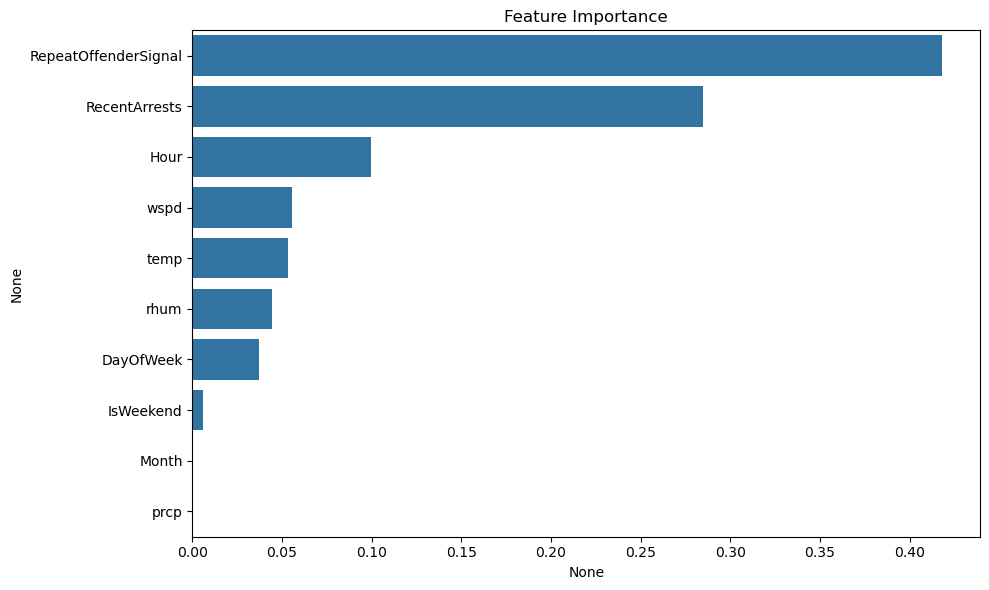

In [12]:
# 9. Evaluation
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, -1]
print(classification_report(y_test, y_pred, zero_division=0))
try:
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
except ValueError as e:
    print("ROC-AUC could not be computed:", e)

feat_imp = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [14]:
# 10. Predict crimes for the next 12 hours from last hour in dataset
print("Predicting next 12 hours of potential crimes...")
last_hour = df['DateHour'].max()
future_hours = pd.date_range(start=last_hour + pd.Timedelta(hours=1), periods=12, freq='h')
forecast_grid = pd.MultiIndex.from_product([future_hours, locations['LatGrid'], locations['LonGrid']], names=['DateHour', 'LatGrid', 'LonGrid'])
forecast_df = pd.DataFrame(index=forecast_grid).reset_index()

forecast_df['Hour'] = forecast_df['DateHour'].dt.hour
forecast_df['DayOfWeek'] = forecast_df['DateHour'].dt.dayofweek
forecast_df['Month'] = forecast_df['DateHour'].dt.month
forecast_df['IsWeekend'] = forecast_df['DayOfWeek'].isin([5, 6]).astype(int)

for col in weather_cols:
    forecast_df[col] = latest_weather[col]

forecast_df['RecentArrests'] = 0
forecast_df['RepeatOffenderSignal'] = 0

forecast_X = forecast_df[features]
forecast_df['PredictedCrimeProb'] = clf.predict_proba(forecast_X)[:, -1]
top_preds = forecast_df.sort_values('PredictedCrimeProb', ascending=False).head(10)
print(top_preds[['DateHour', 'LatGrid', 'LonGrid', 'PredictedCrimeProb']])


📡 Predicting next 12 hours of potential crimes...
                 DateHour  LatGrid  LonGrid  PredictedCrimeProb
29999 2001-01-08 12:00:00    41.68   -87.74            0.294975
28329 2001-01-08 12:00:00    41.68   -87.66            0.294975
28336 2001-01-08 12:00:00    41.68   -87.75            0.294975
28335 2001-01-08 12:00:00    41.68   -87.75            0.294975
28334 2001-01-08 12:00:00    41.68   -87.68            0.294975
28333 2001-01-08 12:00:00    41.68   -87.61            0.294975
28332 2001-01-08 12:00:00    41.68   -87.72            0.294975
28331 2001-01-08 12:00:00    41.68   -87.62            0.294975
28330 2001-01-08 12:00:00    41.68   -87.58            0.294975
28328 2001-01-08 12:00:00    41.68   -87.78            0.294975


In [15]:
# 10. Predict crimes for the next 12 hours from last hour in dataset
print("Predicting next 12 hours of potential crimes...")
last_hour = df['DateHour'].max()
future_hours = pd.date_range(start=last_hour + pd.Timedelta(hours=1), periods=12, freq='h')
forecast_grid = pd.MultiIndex.from_product([future_hours, locations['LatGrid'], locations['LonGrid']], names=['DateHour', 'LatGrid', 'LonGrid'])
forecast_df = pd.DataFrame(index=forecast_grid).reset_index()

forecast_df['Hour'] = forecast_df['DateHour'].dt.hour
forecast_df['DayOfWeek'] = forecast_df['DateHour'].dt.dayofweek
forecast_df['Month'] = forecast_df['DateHour'].dt.month
forecast_df['IsWeekend'] = forecast_df['DayOfWeek'].isin([5, 6]).astype(int)

latest_weather = df[df['DateHour'] == last_hour][weather_cols].mean()
for col in weather_cols:
    forecast_df[col] = latest_weather[col]

forecast_df['RecentArrests'] = 0
forecast_df['RepeatOffenderSignal'] = 0

forecast_X = forecast_df[features]
forecast_df['PredictedCrimeProb'] = clf.predict_proba(forecast_X)[:, -1]
top_preds = forecast_df.sort_values('PredictedCrimeProb', ascending=False).head(10)
print(top_preds[['DateHour', 'LatGrid', 'LonGrid', 'PredictedCrimeProb']])


📡 Predicting next 12 hours of potential crimes...
                 DateHour  LatGrid  LonGrid  PredictedCrimeProb
29999 2001-01-08 12:00:00    41.68   -87.74            0.294975
28329 2001-01-08 12:00:00    41.68   -87.66            0.294975
28336 2001-01-08 12:00:00    41.68   -87.75            0.294975
28335 2001-01-08 12:00:00    41.68   -87.75            0.294975
28334 2001-01-08 12:00:00    41.68   -87.68            0.294975
28333 2001-01-08 12:00:00    41.68   -87.61            0.294975
28332 2001-01-08 12:00:00    41.68   -87.72            0.294975
28331 2001-01-08 12:00:00    41.68   -87.62            0.294975
28330 2001-01-08 12:00:00    41.68   -87.58            0.294975
28328 2001-01-08 12:00:00    41.68   -87.78            0.294975
